## Technical Challenge to detect artifacts on the back seat of a car.
dataset available on https://sviro.kl.dfki.de/data/

you will need to download and extract these datasets:
- https://sviro.kl.dfki.de/download/hyundai-tucson-2/
- https://sviro.kl.dfki.de/download/hyundai-tucson-4/

this notebook runs with tensorflow, keras, opencv, scikit, numpy, and imutils to train and test the images. 

First, we create our MiniVGGNet class. This CNN class has 2 groups of CONV => RELU => CONV => RELU => POOL, followed by FC => RELU layer.

The class receives the width and height of filters and depth of image (color or grayscale image), and how many classes are on the output. The class returns the model constructed as a small VGGNet, this is why it is named as MiniVGGNet.

After each Activation layer, it is executed a BatchNormalization operation. It actually slow the learning rate, but enable higher accuracy levels.

This class is an example on the book 'Deep learning for Computer Vision with Python' from Dr. Adrian Rosebrock

In [1]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

To preprocess the images, i.e., resize the images to feed into the CNN, a function is defined to help on the training and testing phase 

In [2]:
# import the necessary packages
import imutils
import cv2

def preprocess(image, width, height):
    
	# grab the dimensions of the image, then initialize the padding values
	(h, w) = image.shape[:2]

	# if the width is greater than the height then resize along the width
	# otherwise, the height is greater than the width so resize along the height
	if w > h:
		image = imutils.resize(image, width=width)
	else:
		image = imutils.resize(image, height=height)

	# determine the padding values for the width and height to obtain the target dimensions
	padW = int((width - image.shape[1]) / 2.0)
	padH = int((height - image.shape[0]) / 2.0)

	# pad the image then apply one more resizing to handle any rounding issues
	image = cv2.copyMakeBorder(image, padH, padH, padW, padW, cv2.BORDER_REPLICATE)
	image = cv2.resize(image, (width, height))

	# return the pre-processed image
	return image

## Here we define the paths of our datasets
### training Dataset
Contains seat splited images (right, middle, and left seat), separated into 7 folders, one for each class:
- empty seat
- baby on a baby chair
- kid on a kid chair
- adult
- generic items layed over the seat
- empty baby char
- empty kid chair
    
### testing Dataset
Contains the whole image of the back-seat

### temp_weights
Each epoch that produces weights with a smaller function loss than the previous recorded weights will be stored on this folder. 
    

In [24]:
train_dataset = 'tucson_RGB/tucson/train/RGB'
test_dataset = 'tucson_RGB_wholeImage/tucson/test/RGB_wholeImage'

# path to weight output during training
temp_weights = 'output'

## Training the CNN - MiniVGGNet
The CNN will learn 21 classes: the classes listed above repeated over the 3 available seats on the back seat.
Each image on the training dataset will be windowed by a 56 pixels frame.

This next cell outputs the training epochs and at the final, prints the accuracy/loss x epochs of training and validation samples.

From the training dataset, 75% of the images will be used for training, 25% for validation

[INFO] loading training images...
[INFO] scaling pixel intensities...
[INFO] spliting train and test data...
[INFO] changing labels to vectors...
[INFO] compiling model...
[INFO] training network...
Epoch 1/40
141/141 - 57s - loss: 1.2581 - accuracy: 0.6527 - val_loss: 4.2970 - val_accuracy: 0.2127

Epoch 00001: val_loss improved from inf to 4.29696, saving model to output/weights-001-4.2970.hdf5
Epoch 2/40
141/141 - 57s - loss: 0.4001 - accuracy: 0.8744 - val_loss: 1.3395 - val_accuracy: 0.6147

Epoch 00002: val_loss improved from 4.29696 to 1.33948, saving model to output/weights-002-1.3395.hdf5
Epoch 3/40
141/141 - 56s - loss: 0.2706 - accuracy: 0.9167 - val_loss: 2.1295 - val_accuracy: 0.7307

Epoch 00003: val_loss did not improve from 1.33948
Epoch 4/40
141/141 - 58s - loss: 0.1890 - accuracy: 0.9387 - val_loss: 7.3117 - val_accuracy: 0.6993

Epoch 00004: val_loss did not improve from 1.33948
Epoch 5/40
141/141 - 55s - loss: 0.1468 - accuracy: 0.9558 - val_loss: 0.9912 - val_accur

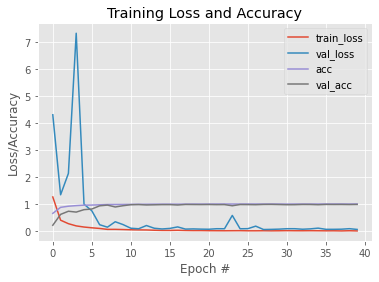

In [12]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# initialize the data and labels
data = []
labels = []

# number of total epochs to train
total_epoch = 40

# size of window
filter = 56

# image color depth (RGB => 3)
depth = 3

# loop over the input images
print("[INFO] loading training images...")

notebook_path = os.path.abspath("Challenge.ipynb")
train_path = os.path.join(os.path.dirname(notebook_path), train_dataset)

for imagePath in paths.list_images(train_path):
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = preprocess(image, filter, filter)
	image = img_to_array(image)
	data.append(image)

	# extract the class label from the image path and update the labels list
	seat = int(imagePath.split(os.path.sep)[-1].split('_')[-3])
	label = int(imagePath.split(os.path.sep)[-2])
	labels.append('{:0>2d}'.format(label+seat*7))

# scale the raw pixel intensities to the range [0, 1]
print("[INFO] scaling pixel intensities...")
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
print("[INFO] spliting train and test data...")
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

# convert the labels from integers to vectors
print("[INFO] changing labels to vectors...")
lb = LabelBinarizer().fit(trainY)
trainY = lb.transform(trainY)
testY = lb.transform(testY)

# initialize the model
print("[INFO] compiling model...")
model = MiniVGGNet.build(width=filter, height=filter, depth=depth, classes=21)

# configure SGD optimizer
opt = SGD(lr=0.01, decay=0.01 / total_epoch, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# construct the callback to save only the *best* model to disk based on the validation loss
fname = os.path.sep.join([temp_weights, "weights-{epoch:03d}-{val_loss:.4f}.hdf5"])
checkpoint = ModelCheckpoint(fname, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [checkpoint]

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	batch_size=32, epochs=total_epoch, callbacks=callbacks, verbose=2)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, total_epoch), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, total_epoch), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, total_epoch), H.history["accuracy"], label="acc")
plt.plot(np.arange(0, total_epoch), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## Testing the results
As stated on the previous cell, the best weight was produced on epoch 28, saved at 'output/weights-028-0.0554.hdf5'
These weights produced a validation accuracy of 0.9827 and loss of 0.0554. This result could be better if fine tuned by learning rate, batch size, class weight, etc.  

## The whole back seat image is taken for tests.
On the next cell, we take a whole back seat image and split it into 3 images, left seat (l), middle seat (m), and right seat (r). Each of these images will be feeded into the network for prediction, resulting into 21 possible classes, 7 artifacts classes repeated over 3 seats. 

The label classes are the following:
<code>
humanize = { 1:  'l-empty', 2:  'l-baby', 3: 'l-kid', 4: 'l-adult', 5: 'l-item', 6: 'l-baby chair', 7: 'l-chair',
		     8:  'm-empty', 9:  'm-baby', 10:'m-kid', 11:'m-adult', 12:'m-item', 13:'m-baby chair', 14:'m-chair',
			 15: 'r-empty', 16: 'r-baby', 17:'r-kid', 18:'r-adult', 19:'r-item', 20:'r-baby chair', 21:'r-chair', }
</code>

[INFO] loading pre-trained network...
[INFO] prediction: 4 8 18


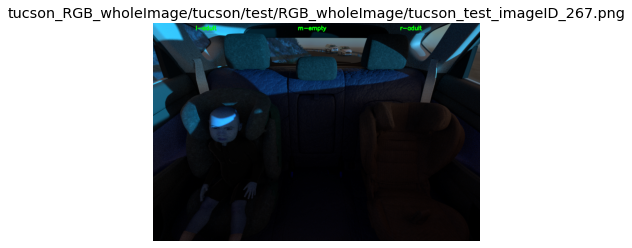

[INFO] prediction: 1 14 15


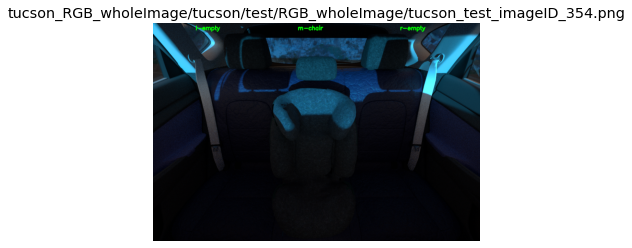

[INFO] prediction: 4 8 11


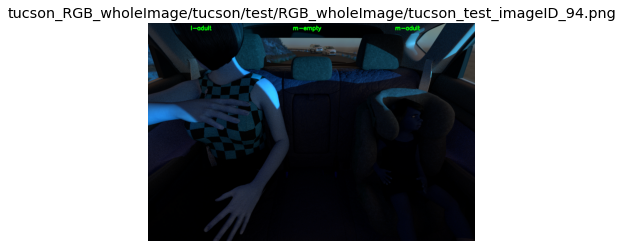

[INFO] prediction: 4 8 18


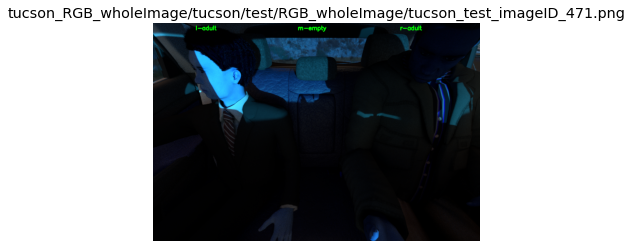

[INFO] prediction: 5 8 15


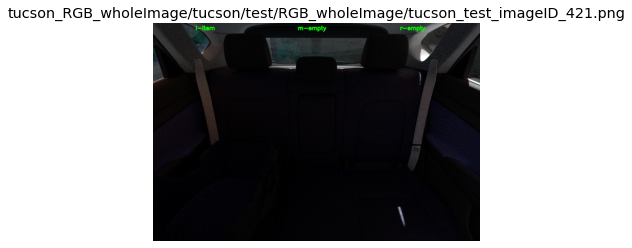

In [29]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import numpy as np
import imutils
import cv2

filter = 56
depth = 3

# load the pre-trained network
print("[INFO] loading pre-trained network...")
model = load_model('output/weights-028-0.0554.hdf5')

# randomy sample a few of the input images
imagePaths = list(paths.list_images(test_dataset))
imagePaths = np.random.choice(imagePaths, size=(5,),replace=False)

# Are we handling a whole image?
whole_image = True

# imagePaths = ['tucson_RGB_wholeImage/tucson/train/RGB_wholeImage/tucson_train_imageID_0_GT_6_6_0.png']

# loop over the image paths
for imagePath in imagePaths:

	# read image from dataset
	image = cv2.imread(imagePath)

	# Are we handling a whole image? -> let's split it into 3
	if whole_image:
		(h, w) = image.shape[:2]
		# generate 3 slices of 550hx250w
		img0 = image[70:(70+550), 130:(130+250)].copy()
		img1 = image[70:(70+550), 363:(363+250)].copy()
		img2 = image[70:(70+550), 582:(582+250)].copy()
		#cv2.imshow("left", img0)
		#cv2.imshow("middle", img1)
		#cv2.imshow("right", img2)
		#cv2.waitKey(0)
		test = [ img0, img1, img2 ]
	else:
		test = [ image ]

	output = image
	predictions = []

	humanize = { 1: 'l-empty', 2: 'l-baby', 3:'l-kid', 4:'l-adult', 5:'l-item', 6:'l-baby chair', 7:'l-chair',
				 8: 'm-empty', 9: 'm-baby', 10:'m-kid', 11:'m-adult', 12:'m-item', 13:'m-baby chair', 14:'m-chair',
				 15: 'r-empty', 16: 'r-baby', 17:'r-kid', 18:'r-adult', 19:'r-item', 20:'r-baby chair', 21:'r-chair',}

	for idx, img in enumerate(test):
		# pre-process the ROI and classify it
		roi = preprocess(img, filter, filter)
		roi = np.expand_dims(img_to_array(roi), axis=0) / 255.0
		pred = model.predict(roi).argmax(axis=1)[0] + 1
		predictions.append(str(pred))

		cv2.putText(output, str(humanize.get(pred)), (125+idx*300, 20),
			cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

	# show the output image
	print("[INFO] prediction: {}".format(" ".join(predictions)))
	plt.imshow(output)
	plt.title(imagePath)
	plt.axis('off')
	plt.show()
    

## Conclusion
It is possible to see that the CNN recognizes always correctly the seat position but makes some mistakes on the respective artifact class. Still, success is greater than the error. As the accuracy of the network reached 98%, it tells us that the CNN needs some more improvement. In this case, weighting the classes will probably fix this issue, once images for empty seat are greater in number than other classes.